In [119]:
import tensorflow as tf
import keras as ks
from keras import models
from keras import metrics
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection

In [120]:
rawdata=pd.read_csv('/content/GOOG.csv').round(3)

In [121]:
rawdata=rawdata.dropna()
rawdata

,Date,Open,High,Low,Close,Adj Close,Volume,Interest,Currency,Inflation,Day,Month
0,2004-08-20,2.516,2.717,2.503,2.698,2.698,458857488.0,4.28,0.550,2.7,20,8
1,2004-08-23,2.758,2.826,2.716,2.725,2.725,366857939.0,4.28,0.550,2.7,23,8
2,2004-08-24,2.771,2.780,2.580,2.612,2.612,306396159.0,4.28,0.550,2.7,24,8
3,2004-08-25,2.614,2.690,2.587,2.640,2.640,184645512.0,4.28,0.550,2.7,25,8
4,2004-08-26,2.614,2.689,2.607,2.688,2.688,142572401.0,4.28,0.550,2.7,26,8
...,...,...,...,...,...,...,...,...,...,...,...,...
4680,2023-03-24,105.740,106.160,104.740,106.060,106.060,25245000.0,3.66,0.824,5.0,24,3
4681,2023-03-27,105.320,105.400,102.630,103.060,103.060,25393400.0,3.66,0.824,5.0,27,3
4682,2023-03-28,103.000,103.000,100.280,101.360,101.360,24913500.0,3.66,0.824,5.0,28,3
4683,2023-03-29,102.720,102.820,101.030,101.900,101.900,26148300.0,3.66,0.824,5.0,29,3


In [122]:
data=pd.DataFrame()
data['Open']=rawdata['Open'].astype(np.float64)
data['High']=rawdata['High'].astype(np.float64)
data['Low']=rawdata['Low'].astype(np.float64)
data['Close']=rawdata['Close'].astype(np.float64)
data['Currency']=rawdata['Currency'].astype(np.float64)
data['Interest']=rawdata['Interest'].astype(np.float64)
data['Inflation']=rawdata['Inflation'].astype(np.float64)
data['Day']=rawdata['Day'].astype(np.int64)
data['Month']=rawdata['Month'].astype(np.int64)
data.head()

,Open,High,Low,Close,Currency,Interest,Inflation,Day,Month
0,2.516,2.717,2.503,2.698,0.55,4.28,2.7,20,8
1,2.758,2.826,2.716,2.725,0.55,4.28,2.7,23,8
2,2.771,2.780,2.580,2.612,0.55,4.28,2.7,24,8
3,2.614,2.690,2.587,2.640,0.55,4.28,2.7,25,8
4,2.614,2.689,2.607,2.688,0.55,4.28,2.7,26,8


In [123]:
train=data.iloc[:int(0.8*len(data))]
test=data.iloc[int(0.8*len(data)):]

In [124]:
def sliding_window(stockdata):
  window_size=7
  windowed_data=[]
  for i in range(len(stockdata)-window_size):
      window=stockdata[i:i+window_size]
      windowed_data.append(window)
  return np.array(windowed_data)

In [125]:
#run to keep batches ordered
X=sliding_window(train)
Y=train['Close'][7:]
TestingX=sliding_window(test)
TestingY=test['Close'][7:]

In [126]:
x_train,x_test,y_train,y_test=model_selection.train_test_split(X,Y,test_size=0.2)

In [132]:
metric=[metrics.RootMeanSquaredError(),metrics.MeanAbsoluteError(),metrics.MeanAbsolutePercentageError(),metrics.MeanSquaredLogarithmicError()]
def modelbuild():
    model = models.Sequential()
    model.add(ks.layers.LSTM(128, return_sequences=True,activation='relu', input_shape=(7,9),dropout=0.1,recurrent_dropout=0.1))
    model.add(ks.layers.SimpleRNN(32,activation='relu'))
    model.add(ks.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=metric)
    return model

In [128]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 7, 256)            272384    
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 32)                9248      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 281,665
Trainable params: 281,665
Non-trainable params: 0
_________________________________________________________________


In [133]:
model=modelbuild()
stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),callbacks=[stop])
#history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test))

test_loss, rmse, mae, mape, msle = model.evaluate(x_test, y_test, verbose=2)

print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)

Epoch 1/10
94/94 [==============================] - 11s 54ms/step - loss: 57.6188 - root_mean_squared_error: 7.5907 - mean_absolute_error: 3.4619 - mean_absolute_percentage_error: 16.0482 - mean_squared_logarithmic_error: 0.3350 - val_loss: 1.5024 - val_root_mean_squared_error: 1.2257 - val_mean_absolute_error: 0.9265 - val_mean_absolute_percentage_error: 5.2399 - val_mean_squared_logarithmic_error: 0.0044
Epoch 2/10
94/94 [==============================] - 3s 33ms/step - loss: 3.1179 - root_mean_squared_error: 1.7658 - mean_absolute_error: 1.2105 - mean_absolute_percentage_error: 5.9020 - mean_squared_logarithmic_error: 0.0052 - val_loss: 3.1809 - val_root_mean_squared_error: 1.7835 - val_mean_absolute_error: 1.2042 - val_mean_absolute_percentage_error: 5.1905 - val_mean_squared_logarithmic_error: 0.0038
Epoch 3/10
94/94 [==============================] - 3s 35ms/step - loss: 2.0886 - root_mean_squared_error: 1.4452 - mean_absolute_error: 1.0044 - mean_absolute_percentage_error: 4.913

In [134]:
test_loss, rmse, mae, mape, msle = model.evaluate(TestingX,TestingY,verbose=1)
print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)
print("Want to save model?")
c=input()
if c=='y':
  ks.Model.save(model,'/content/models')

30/30 [==============================] - 0s 8ms/step - loss: 29.5868 - root_mean_squared_error: 5.4394 - mean_absolute_error: 4.4505 - mean_absolute_percentage_error: 4.4209 - mean_squared_logarithmic_error: 0.0029

Mean Squared Error:  29.58677101135254
Root Mean Squared Error:  5.4393720626831055
Mean Absolute Error:  4.45046854019165
Mean Absolute Percentage Error:  4.4208598136901855
Mean Squared Logarithmic Error:  0.002852000528946519
Want to save model?
y


147/147 [==============================] - 2s 10ms/step


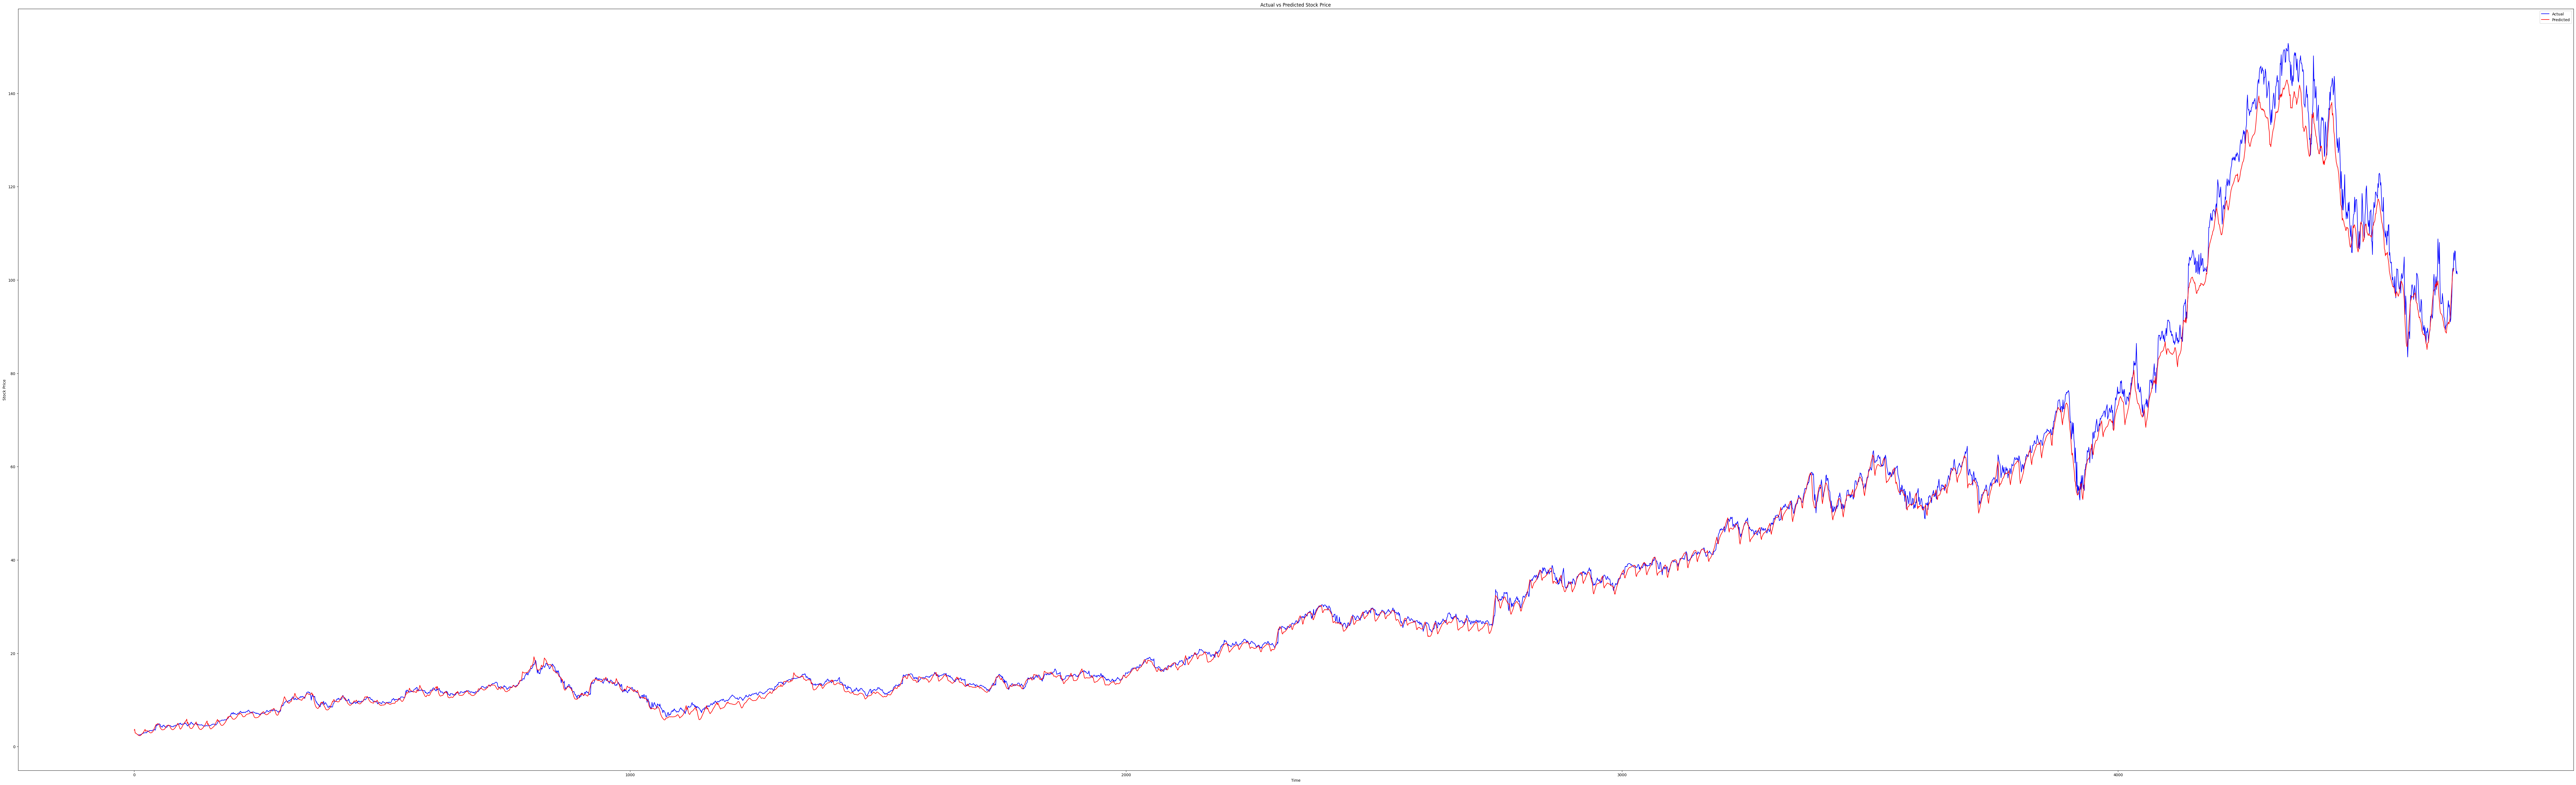

In [135]:
predicted_prices=model.predict(sliding_window(data))
actual_prices=data['Close'][7:]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(120,36))
plt.plot(actual_prices, color='blue', label='Actual')
plt.plot(predicted_prices, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.show()